In [41]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score, roc_auc_score
from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler
from imblearn.under_sampling import NearMiss, TomekLinks, ClusterCentroids
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.utils.class_weight import compute_class_weight


import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Conv1D, BatchNormalization, Activation, MaxPooling1D
from tensorflow.keras.layers import SpatialDropout1D, GlobalAveragePooling1D, Dense, Dropout
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import BinaryCrossentropy

# :https://claude.ai/chat/d2308f5c-b8e1-49de-8e54-05d92dc8017b
# https://grok.com/c/29b64892-22ce-4423-b6c5-26e01ed4bef6
# https://chatgpt.com/c/68d13b9b-5790-832b-aad0-858310b6b5dd

In [42]:
# Loading the data
df = pd.read_csv('cleaned_room_occupay.csv')
df.head()

,Temperature,Humidity,CO2,Occupancy,minute,hour,day
0,23.70,26.272,749.20,1,19,14,2
1,23.72,26.290,760.40,1,19,14,2
2,23.73,26.230,769.67,1,21,14,2
3,23.72,26.125,774.75,1,22,14,2
4,23.75,26.200,779.00,1,23,14,2


In [43]:
df.shape

(20560, 7)

In [44]:
# Making label and features
X = df.drop('Occupancy', axis=1).values
y = df['Occupancy'].values


# Calculating class weights to handle class imbalance
class_weights = compute_class_weight('balanced', classes=np.unique(y), y=y)
class_weight_dict = {0: class_weights[0], 1: class_weights[1]}
class_weight_dict



n = len(X)
train_size=0.7
val_size=0.15

train_end = int(n * train_size)
val_end = int(n * (train_size + val_size))
X_train = X[:train_end]
y_train = y[:train_end]
    
X_val = X[train_end:val_end]
y_val = y[train_end:val_end]
    
X_test = X[val_end:]
y_test = y[val_end:]


scaler = RobustScaler()
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)
X_test = scaler.transform(X_test)
print('Shape of training data:', X_train.shape, y_train.shape)
print('Shape of validation data:', X_val.shape, y_val.shape)
print('Shape of test data:', X_test.shape, y_test.shape)


Shape of training data: (14391, 6) (14391,)
Shape of validation data: (3085, 6) (3085,)
Shape of test data: (3084, 6) (3084,)


In [45]:
# Creating sequences:
def create_windows(X, y, window_size=60, stride=1):
    X_windows = []
    y_windows = []
    for i in range(0, len(X) - window_size + 1, stride):
        X_windows.append(X[i:i+window_size])
        y_windows.append(y[i+window_size-1])
    return np.array(X_windows), np.array(y_windows)
# Applying the function:
X_train, y_train = create_windows(X_train, y_train)
X_val, y_val = create_windows(X_val, y_val)
X_test, y_test = create_windows(X_test, y_test)

print('Training sequences shape:', X_train.shape)
print('Training class shape:', y_train.shape)

Training sequences shape: (14332, 60, 6)
Training class shape: (14332,)


In [46]:
num_0 = (y_train == 0).sum()
num_1 = (y_train == 1).sum()
total = len(y_train)
weight_for_0 = total / (2 * num_0)
weight_for_1 = total / (2 * num_1)
class_weights = {0: weight_for_0, 1: weight_for_1}
print("Class weights:", class_weights)

Class weights: {0: 0.6625982431807674, 1: 2.0375319874893374}


In [47]:
model = Sequential([
    Conv1D(32, 5, padding='same', use_bias=False, input_shape=(60, X_train.shape[2]), kernel_regularizer=l2(0.0001)),
    BatchNormalization(), Activation('relu'),
    SpatialDropout1D(0.15),
    MaxPooling1D(2),

    Conv1D(64, 5, padding='same', use_bias=False, kernel_regularizer=l2(0.0001)),
    BatchNormalization(), Activation('relu'),
    SpatialDropout1D(0.1),

    GlobalAveragePooling1D(),
    Dense(64, activation='relu', kernel_regularizer=l2(0.0001)),
    Dropout(0.1),
    Dense(1, activation='sigmoid')
])
model.summary()

d:\ML&DE\Deep_Learning\.venv\lib\site-packages\keras\src\layers\convolutional\base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d_4 (Conv1D)               │ (None, 60, 32)         │           960 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 60, 32)         │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_4 (Activation)       │ (None, 60, 32)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ spatial_dropout1d_4             │ (None, 60, 32)         │             0 │
│ (SpatialDropout1D)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_2 (MaxPooling1D)  │ (None, 30, 32)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_5 (Conv1D)               │ (None, 30, 64)         │        10,240 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 30, 64)         │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_5 (Activation)       │ (None, 30, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ spatial_dropout1d_5             │ (None, 30, 64)         │             0 │
│ (SpatialDropout1D)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling1d_2      │ (None, 64)             │             0 │
│ (GlobalAveragePooling1D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 15,809 (61.75 KB)

 Trainable params: 15,617 (61.00 KB)

 Non-trainable params: 192 (768.00 B)

In [48]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.0005),
    loss=BinaryCrossentropy(label_smoothing=0.05), metrics=['accuracy', tf.keras.metrics.Precision(name='precision')])

In [49]:
early_stop = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True, verbose=1)
# Reducing learning rate when stuck
reduce_lr = ReduceLROnPlateau(monitor='val_loss',factor=0.5, patience=3, verbose=1)

In [50]:
history = model.fit(X_train, y_train, 
    epochs=20, batch_size=256, class_weight=class_weights, callbacks=[early_stop, reduce_lr],
    validation_data=(X_val, y_val),verbose=2)

Epoch 1/20
56/56 - 2s - 34ms/step - accuracy: 0.8000 - loss: 0.4526 - precision: 0.5585 - val_accuracy: 0.9306 - val_loss: 0.4308 - val_precision: 0.9234 - learning_rate: 5.0000e-04
Epoch 2/20
56/56 - 0s - 8ms/step - accuracy: 0.8765 - loss: 0.3392 - precision: 0.6825 - val_accuracy: 0.8761 - val_loss: 0.3891 - val_precision: 0.6206 - learning_rate: 5.0000e-04
Epoch 3/20
56/56 - 0s - 7ms/step - accuracy: 0.8827 - loss: 0.3178 - precision: 0.6916 - val_accuracy: 0.8701 - val_loss: 0.3556 - val_precision: 0.6034 - learning_rate: 5.0000e-04
Epoch 4/20
56/56 - 0s - 7ms/step - accuracy: 0.8870 - loss: 0.3062 - precision: 0.6990 - val_accuracy: 0.8652 - val_loss: 0.3441 - val_precision: 0.5959 - learning_rate: 5.0000e-04
Epoch 5/20
56/56 - 0s - 7ms/step - accuracy: 0.8956 - loss: 0.2995 - precision: 0.7176 - val_accuracy: 0.8629 - val_loss: 0.3436 - val_precision: 0.5892 - learning_rate: 5.0000e-04
Epoch 6/20
56/56 - 0s - 7ms/step - accuracy: 0.9000 - loss: 0.2880 - precision: 0.7250 - val_a

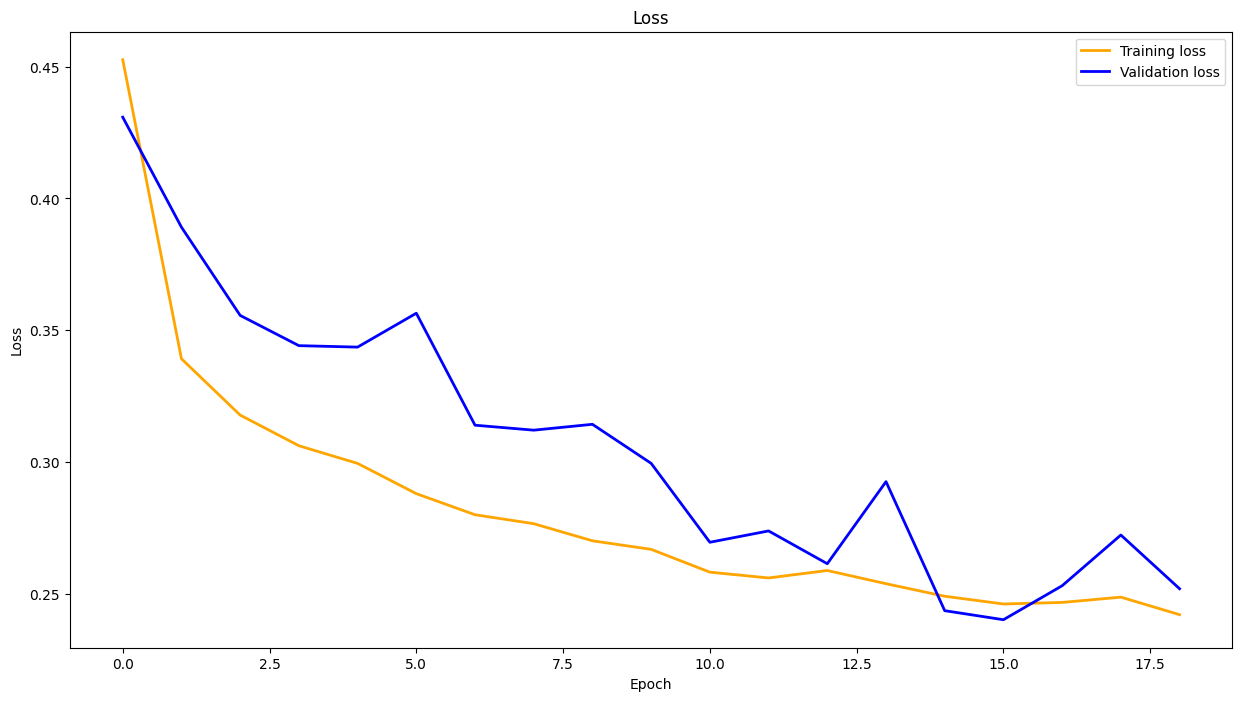

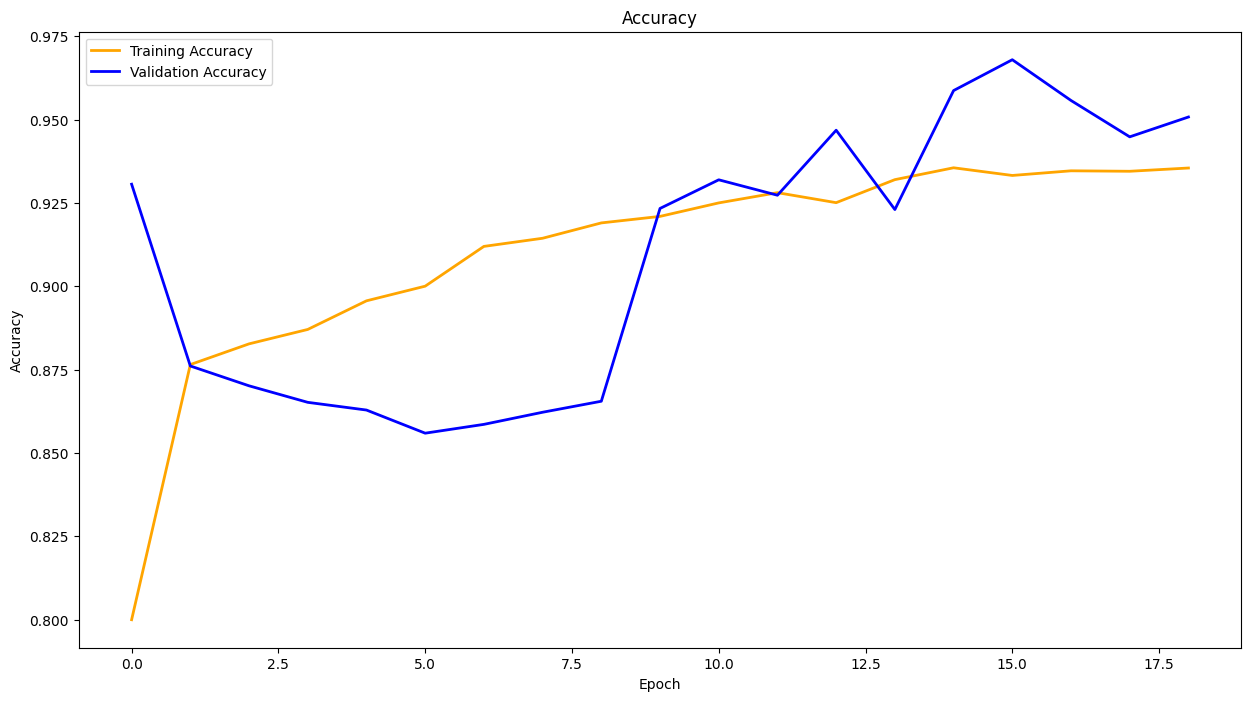

In [51]:
fig, ax = plt.subplots(figsize=(15, 8))
ax.plot(history.history['loss'], label='Training loss', color='orange', linewidth=2, markersize=6)
ax.plot(history.history['val_loss'], label='Validation loss', color='blue', linewidth=2, markersize=6)
ax.set_title('Loss')
ax.set_xlabel('Epoch')
ax.set_ylabel('Loss')
ax.legend()

fig, ax = plt.subplots(figsize=(15, 8))
ax.plot(history.history['accuracy'], label='Training Accuracy', color='orange', linewidth=2, markersize=6)
ax.plot(history.history['val_accuracy'], label='Validation Accuracy', color='blue', linewidth=2, markersize=6)
ax.set_title('Accuracy')
ax.set_xlabel('Epoch')
ax.set_ylabel('Accuracy')
ax.legend()

95/95 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


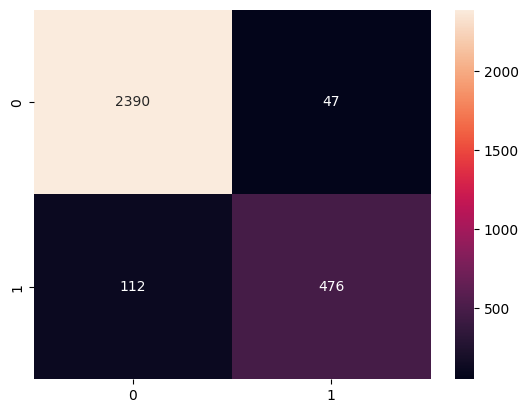

In [52]:
# Predict on test
y_pred_prob = model.predict(X_test)
y_pred = (y_pred_prob > 0.5).astype(int)

# Metrics
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d')
plt.show()

In [53]:
# Classification report
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.96      0.98      0.97      2437
           1       0.91      0.81      0.86       588

    accuracy                           0.95      3025
   macro avg       0.93      0.90      0.91      3025
weighted avg       0.95      0.95      0.95      3025



In [54]:
df.head()

,Temperature,Humidity,CO2,Occupancy,minute,hour,day
0,23.70,26.272,749.20,1,19,14,2
1,23.72,26.290,760.40,1,19,14,2
2,23.73,26.230,769.67,1,21,14,2
3,23.72,26.125,774.75,1,22,14,2
4,23.75,26.200,779.00,1,23,14,2


In [74]:
new_data = {
    'Temperature': [23.5],
    'Humidity': [45.0],
    'CO2': [600.0],
    'minute': [30],
    'hour': [14],
    'day': [11],
}
new_data = pd.DataFrame(new_data)
new_data = scaler.transform(new_data.values)     
seq = seq.reshape(1, 60, new_data.shape[1])
predicted = model.predict(seq)
print(f"Occupancy probability {predicted[0,0]:.2f}%")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
Occupancy probability 0.99%
